In [65]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-28,23.225000,23.415001,23.035000,23.397499,21.604420,161779600
2016-06-29,23.492500,23.637501,23.407499,23.600000,21.791399,146124000
2016-06-30,23.610001,23.942499,23.575001,23.900000,22.068417,143345600
2016-07-01,23.872499,24.117500,23.832500,23.972500,22.135355,104106000
2016-07-05,23.847500,23.850000,23.615000,23.747499,21.927599,110820800
...,...,...,...,...,...,...
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300
2023-06-23,185.550003,187.559998,185.009995,186.679993,186.679993,53079300


In [66]:
# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences for LSTM and GRU models
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Create sequences for LSTM and GRU models
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

RMSE: 0.02349725332826485
MAE: 0.01795734679149089
R2: 0.9247241730310929


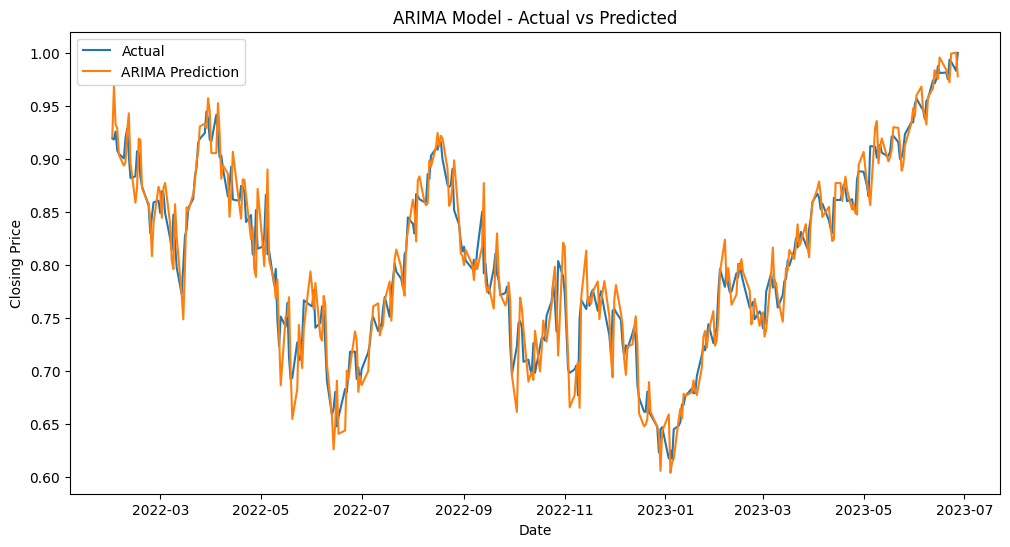

In [67]:
history = [x for x in train_data]
arima_predictions = list()
for t in range(len(test_data)):
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
arima_r2 = r2_score(test_data, arima_predictions)
print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"R2: {arima_r2}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label='ARIMA Prediction')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


11/11 [==============================] - 0s 2ms/step
RMSE: 4.005896147587683
MAE: 3.2099492986638984
R2: 0.9184112292870081


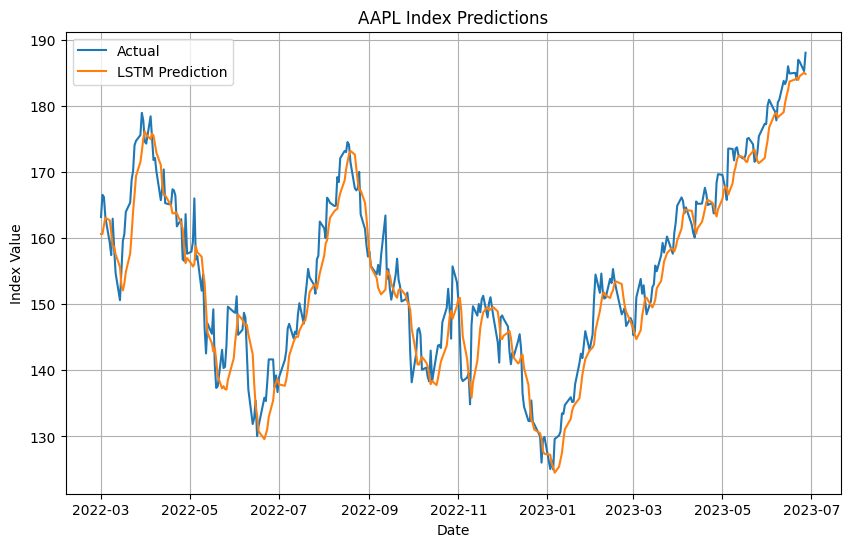

In [71]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size+sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size+sequence_length:], lstm_predictions)
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")


# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], lstm_predictions, label='LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()


11/11 [==============================] - 0s 3ms/step
RMSE: 3.1640829568745144
MAE: 2.4917759021839223
R2: 0.9490989500826056


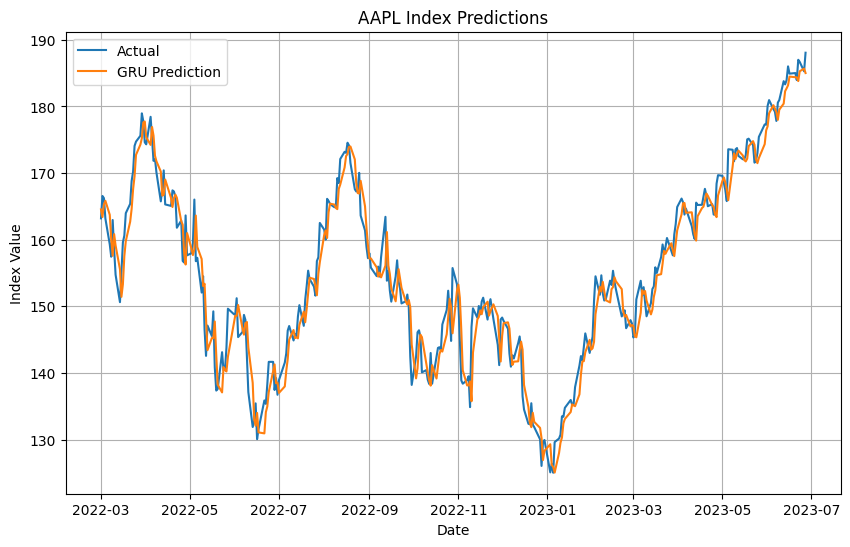

In [72]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions.reshape(-1, 1))

# Calculate indexes
gru_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], gru_predictions))
gru_mae = mean_absolute_error(data[train_size+sequence_length:], gru_predictions)
gru_r2 = r2_score(data[train_size+sequence_length:], gru_predictions)
print(f"RMSE: {gru_rmse}")
print(f"MAE: {gru_mae}")
print(f"R2: {gru_r2}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], gru_predictions, label='GRU Prediction')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()
